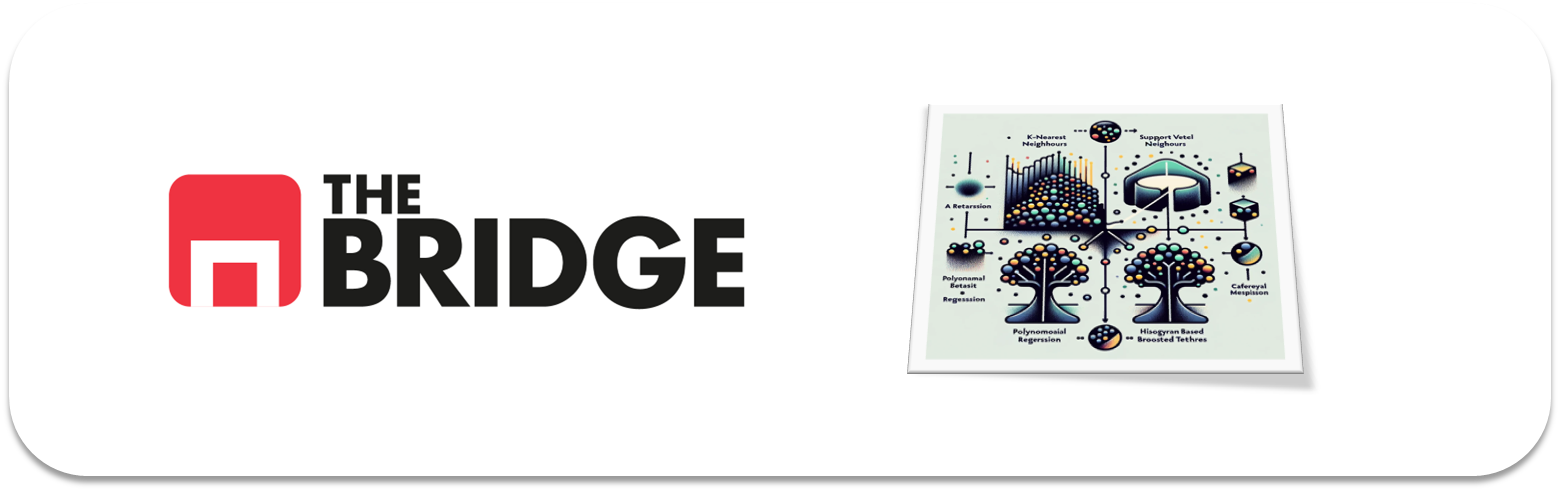

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [49]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from xgboost import XGBClassifier

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [50]:
df = pd.read_csv('./data/credit_npo.csv')

In [51]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

1. **SeriousDlqin2yrs**: Indicador binario (1, 0) de si la persona ha tenido dificultades financieras serias.
2. **RevolvingUtilizationOfUnsecuredLines**: Porcentaje de uso del crédito no asegurado disponible.
3. **age**: Edad del individuo.
4. **NumberOfTime30-59DaysPastDueNotWorse**: Número de veces que el pago estuvo atrasado entre 30 y 59 días sin empeorar.
5. **DebtRatio**: Relación entre deudas totales y el ingreso mensual total.
6. **MonthlyIncome**: Ingresos mensuales del individuo.
7. **NumberOfOpenCreditLinesAndLoans**: Cantidad de líneas de crédito y préstamos abiertos.
8. **NumberOfTimes90DaysLate**: Número de veces que el pago estuvo atrasado más de 90 días.
9. **NumberRealEstateLoansOrLines**: Número de préstamos o líneas de crédito hipotecario.
10. **NumberOfTime60-89DaysPastDueNotWorse**: Número de veces que el pago estuvo atrasado entre 60 y 89 días sin empeorar.
11. **NumberOfDependents**: Número de dependientes económicamente.

In [53]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [54]:
categorical_var = ['SeriousDlqin2yrs']
numerical_var = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Estamos tratando un problema de clasificacion binaria.

In [55]:
target = 'SeriousDlqin2yrs'

### #1.3
Pinta la distribución de frecuencias del target y coméntala

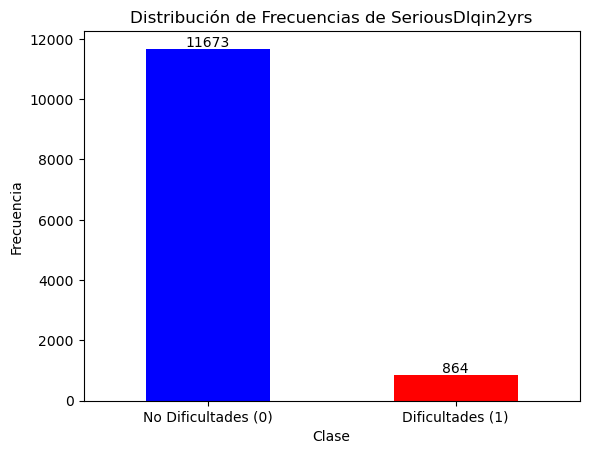

In [56]:
freq = df['SeriousDlqin2yrs'].value_counts()

freq.plot(kind = 'bar', color = ['blue', 'red'])
plt.title('Distribución de Frecuencias de SeriousDlqin2yrs')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(ticks = [0, 1], labels = ['No Dificultades (0)', 'Dificultades (1)'], rotation = 0)

for i in range(len(freq)):
    plt.text(i, freq[i] + 50, str(freq[i]), ha = 'center')

plt.show()

El grafico muestra la distribucion de la frecuencia del target 'SeriousDlqin2yrs'.<br>
Clase 0 = No tiene dificultades financieras. 11673 personas.<br>
Clase 1 = Si que tiene dificultades financieras. 864 personas.<br>
El grigo revela un notable desbalance entre las 2 clases, siendo significativamente mayor las personas que no tiene dificultades financieras.<br> 

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

Imputacion nulos 

In [75]:
df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean(), inplace = True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].mode()[0], inplace = True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         12537 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

Train / Test

In [59]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

MiniEDA

In [60]:
features_num = train_set.columns.to_list()
features_num.remove(target)

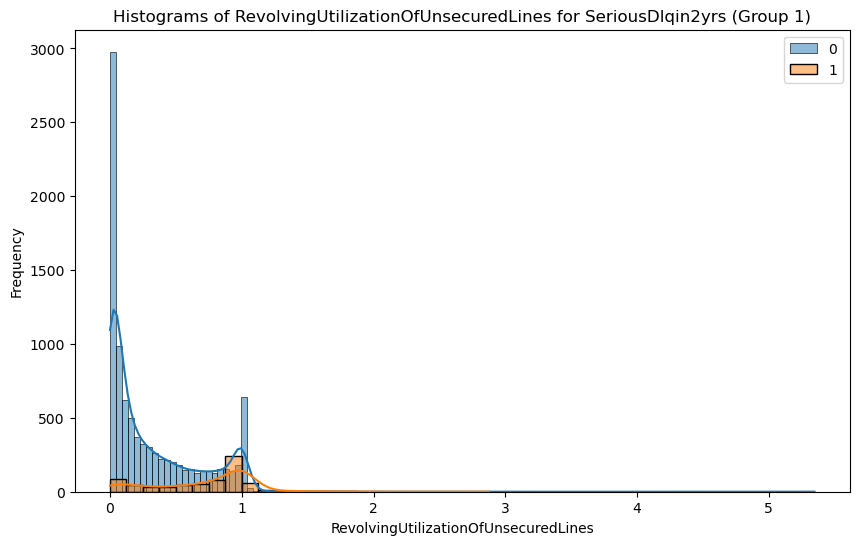

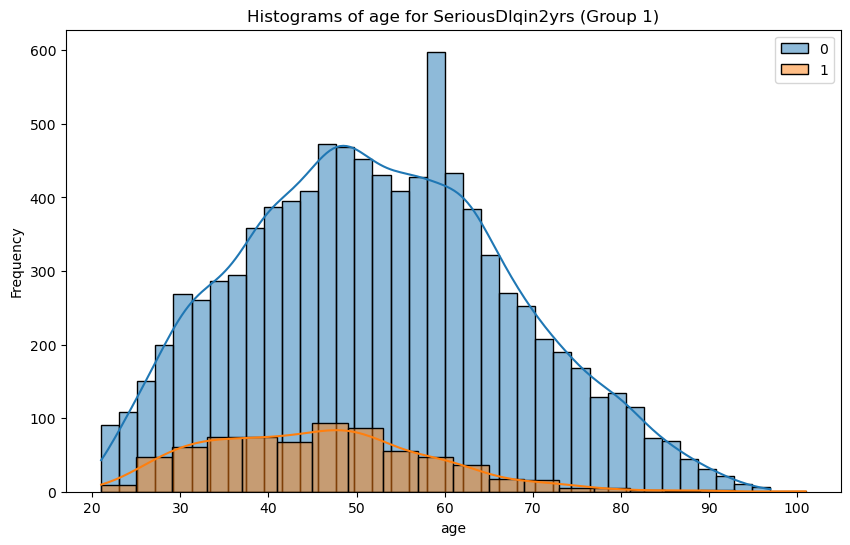

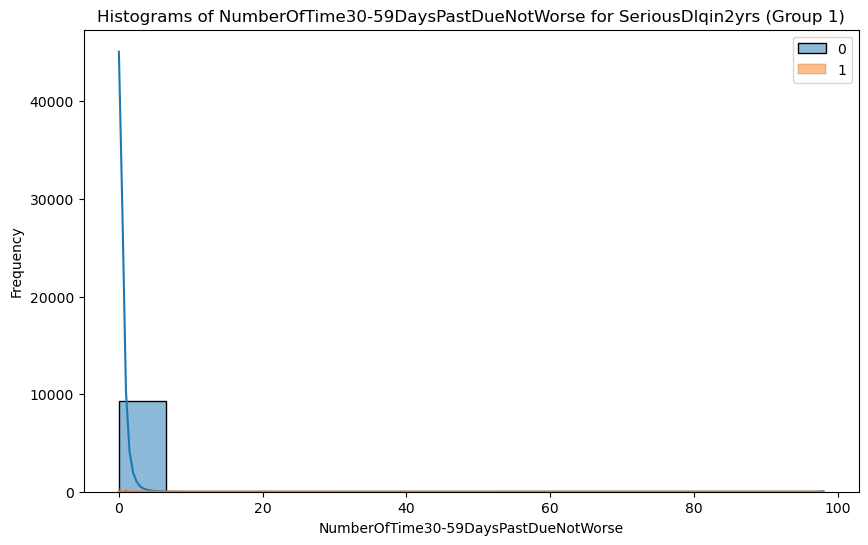

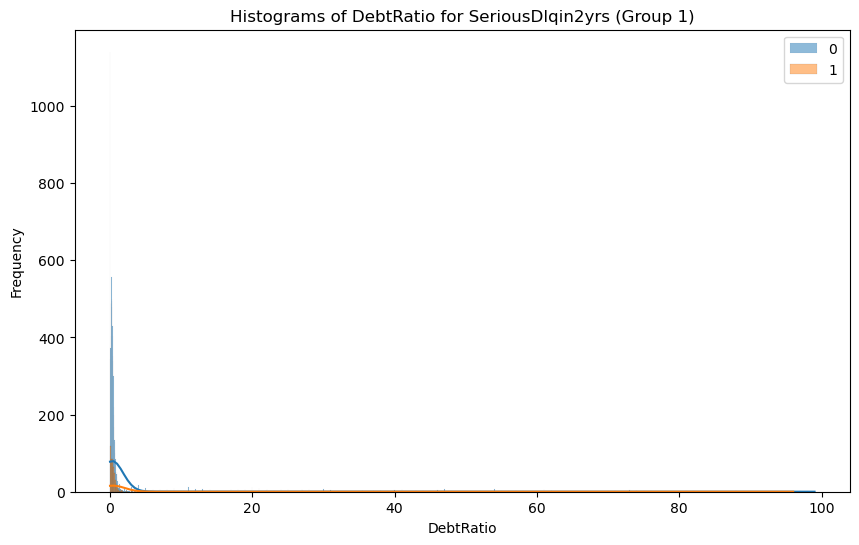

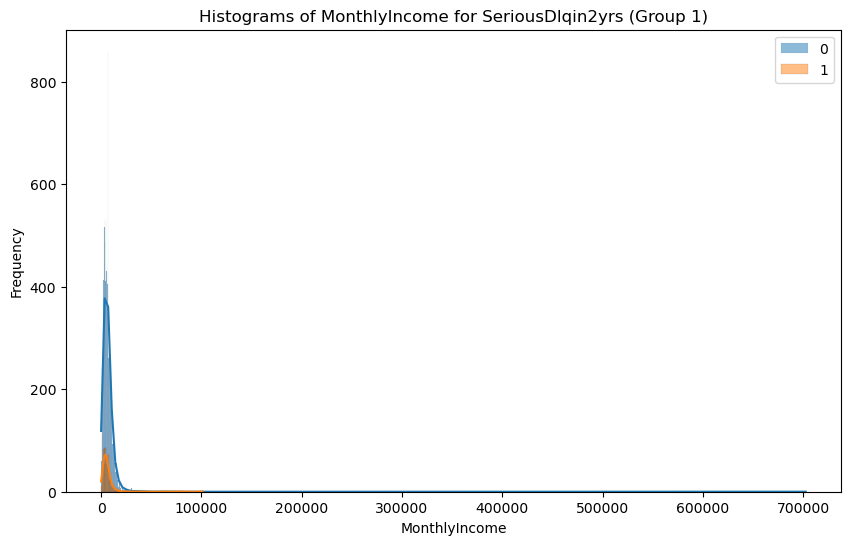

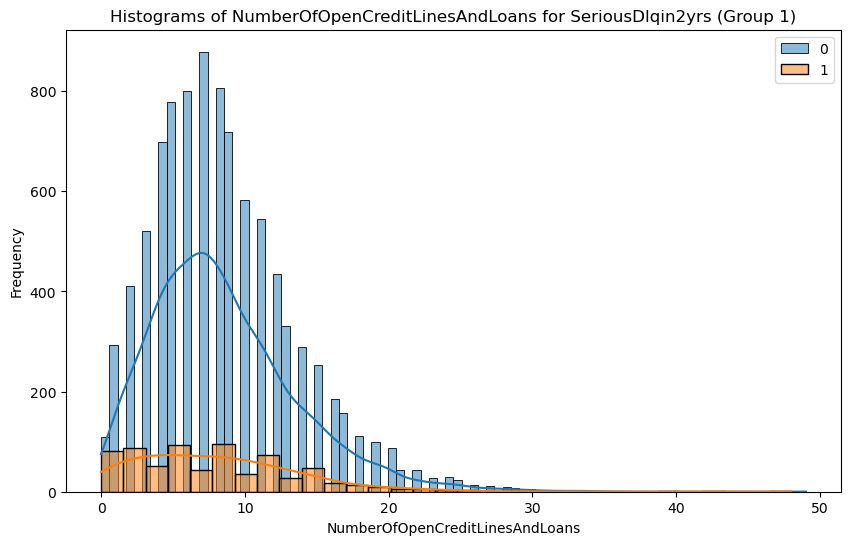

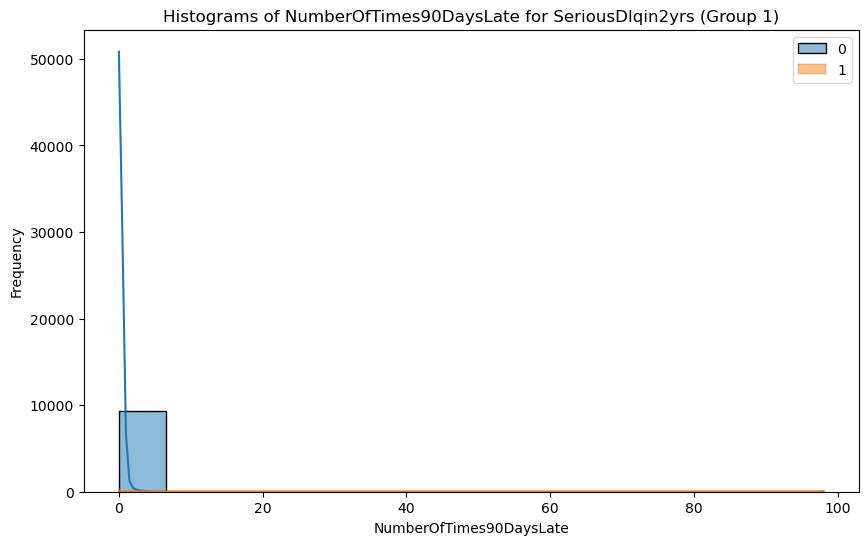

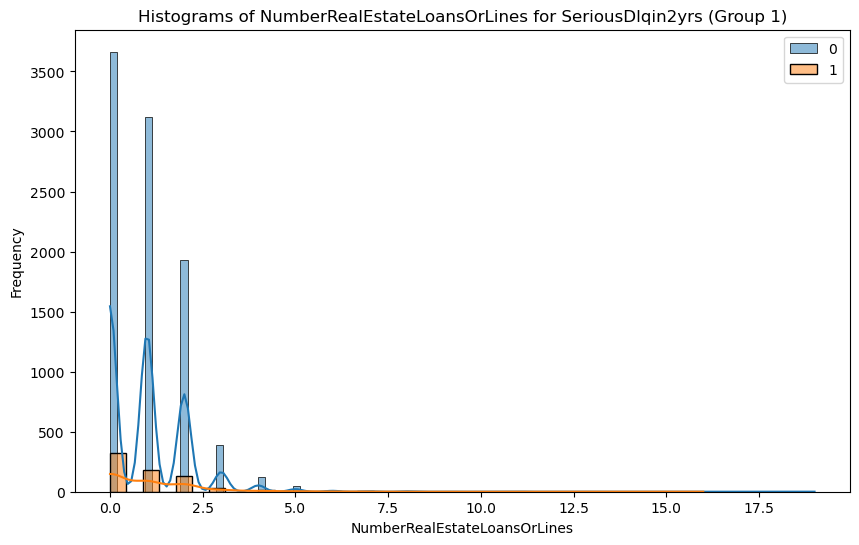

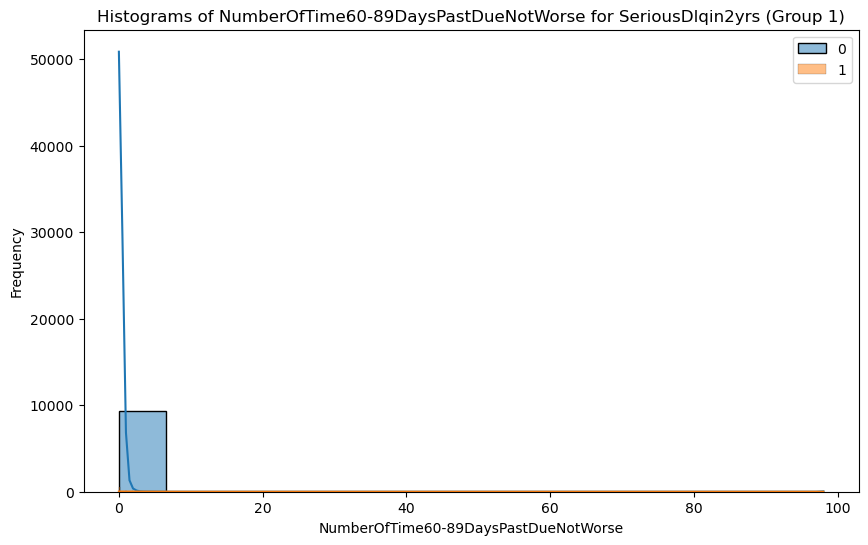

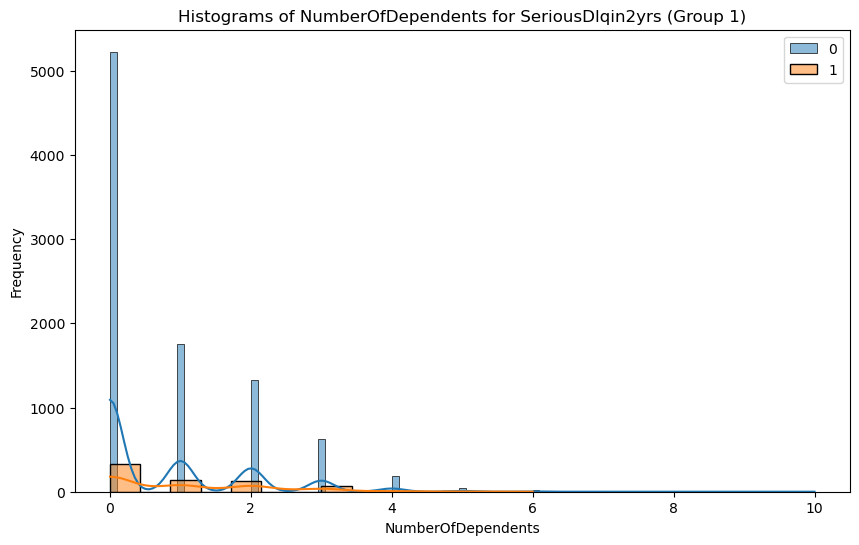

In [61]:
for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col = target, num_col = col, group_size = 3)

In [62]:
selected_var = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']

In [63]:
train_set.corr()['SeriousDlqin2yrs'].round(2)

SeriousDlqin2yrs                        1.00
RevolvingUtilizationOfUnsecuredLines    0.29
age                                    -0.12
NumberOfTime30-59DaysPastDueNotWorse    0.11
DebtRatio                              -0.02
MonthlyIncome                          -0.02
NumberOfOpenCreditLinesAndLoans        -0.02
NumberOfTimes90DaysLate                 0.11
NumberRealEstateLoansOrLines            0.01
NumberOfTime60-89DaysPastDueNotWorse    0.09
NumberOfDependents                      0.05
Name: SeriousDlqin2yrs, dtype: float64

Tratamiento de Features

In [64]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [65]:
for col in features_num:
    if col != "age":
        train_set_scaled[col] = np.log(train_set_scaled[col] + 1) 
        test_set_scaled[col] = np.log(test_set_scaled[col] + 1)

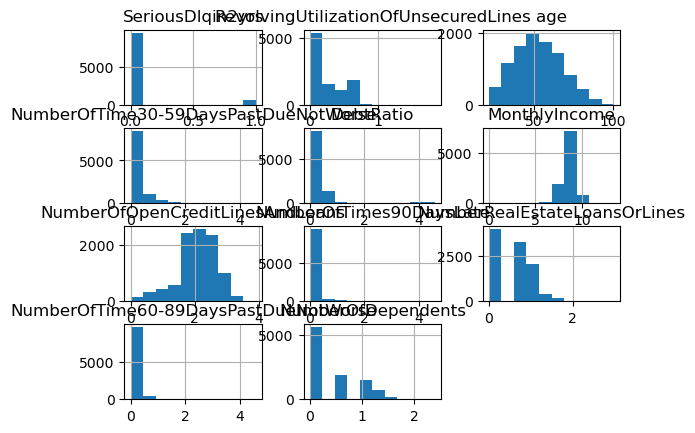

In [66]:
train_set_scaled.hist();

In [71]:
scaler = StandardScaler()
train_set_scaled[features_num] = scaler.fit_transform(train_set_scaled[features_num])
test_set_scaled[features_num] = scaler.transform(test_set_scaled[features_num])

In [70]:
X_train = train_set[features_num]
X_train_scaled = train_set_scaled[features_num]
y_train = train_set[target]

X_test = test_set[features_num]
X_test_scaled = test_set_scaled[features_num]
y_test = test_set[target]

KNN

In [69]:
knn_clf = KNeighborsClassifier(n_neighbors = 3)
knn_clf.fit(X_train_scaled, y_train)

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Entrenamiento y evaluacion de modelos

Optimizacion de hiperparametros para RandomForestClassifier